Чернышова Дана

# **Creating CNN from scratch**

In this assignment, you will implement convolutional and pooling layers in Python using NumPy, including both forward propagation and backward propagation.

This notebook contains 7 tasks. For easy navigation, you can use the table of contents.

**After completing this homework, you will be able to:**

* explain how the convolution operation works;
* identify the components used in a convolutional neural network (kernel, stride, padding, ...) and their purpose;
* apply different types of pooling operation;
* build a main part of the convolutional neural network almost from scratch.

**Prerequisites:** `NumPy` basics, linear algebra basics, understanding of the main components of the CNN.

<a name='0'></a>
## **Reminder of the CNN structure**

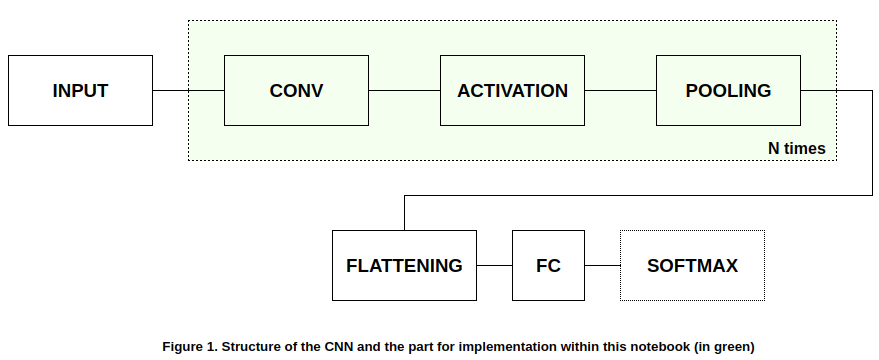

<a name='1'></a>
## **1. Importing packages**

In this assignment you will use the following packages:
* [NumPy](http://numpy.org) package — fundamental package for efficient scientific computing with Python;
* [Matplotlib](http://matplotlib.org) package — one of the most popular libraries to plot graphs in Python.

Please note that `np.random.seed(39)` is used to keep all the random function calls consistent. This helps to grade your work.

In [1]:
# DO NOT CHANGE THE CODE OF THIS CELL
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(39)

<a name='2'></a>
## **2. Building convolutional layer**

In this part, you will build every step of the convolution layer. You will first implement two helper functions: one for zero padding and the other for computing the convolution function itself.

<a name='2.1'></a>
### **2.1 Padding**

Padding operation adds specified values (we will use zero-padding) around the border of an image:

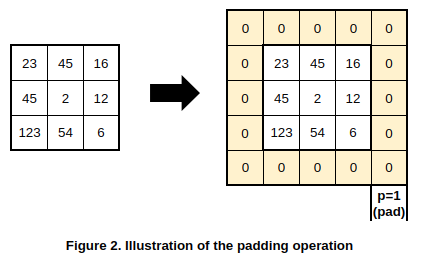

#### **Prerequisites for using padding:**
* to prevent shrinking the image at each convolution step (this is especially critical for deep neural networks with a large number of layers);
* to prevent throwing away information near the edges of the image (because with no-padding pixels near the edge are used in convolution much less than pixels in the middle).

#### **Valid and same convolutions**
The most common cases in CNN's are valid and same convolutions.
* `«valid»` convolution means no padding. In this case, the size of the output image after convolution operation is changed the following way: $[n\times n] * [f\times f] \rightarrow [(n - f + 1) \times (n - f + 1)] $, where $n\times n$ is the input image size and $f\times f$ is the size of the convolutional kernel.
* `«same»` convolution means using padding so the output size of the image after convolution is the same as the input size. The appropriate padding $p$ in this case is selected taking into account the size of the input image $n$ and the size of the convolution kernel $f$.

<a name='2.1.1'></a>
#### **TASK 1 (answer the folowing questions)**

1. With the specified image and the convolution kernel sizes $n, f$, write how padding $p$ will be calculated if we want the image size to stay the same after applying the convolution operation.

2. We have an image of size $128\times 128$ and we want to perform a «same» convolution operation with a kernel of size $5\times 5$. Which pad should we use?

3. When using the «same» convolution, what restriction is reasonable to impose on the size of the convolution kernel and why?

1) p = (k-1)/2 (for odd k), p = k/2 (for even k)
2) p = 2
3) better keep the convolution kernel size to odd values since this ensures symmetric padding

<a name='2.1.2'></a>
#### **TASK 2 (implement zero-padding function)**

Implement the following function, which pads all the images of a batch of examples X with zeros.
You can use [np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html) function to do this.

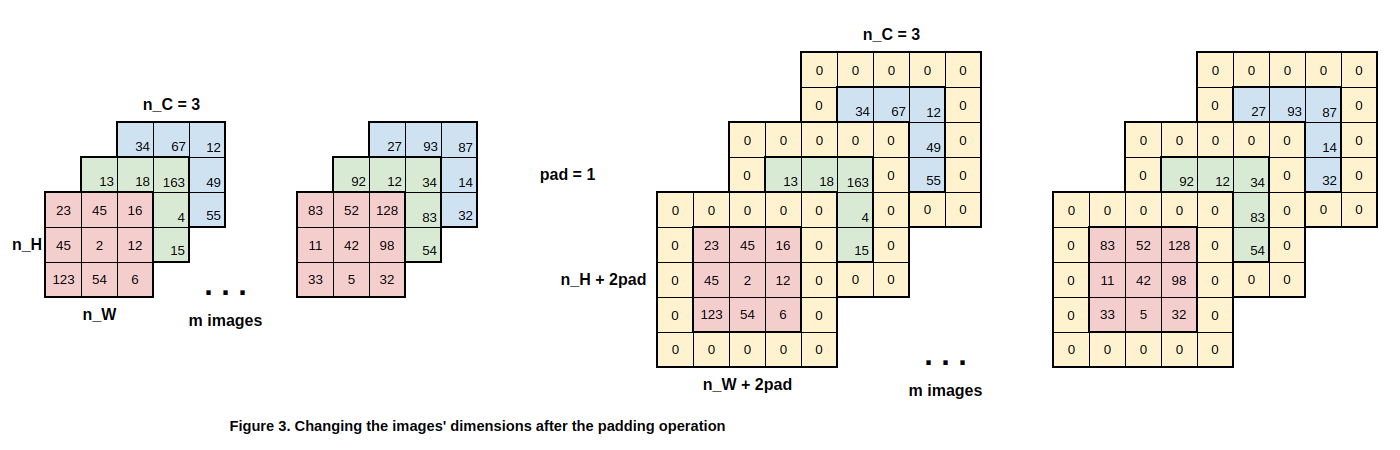

In [8]:
# YOU SHOULD CHANGE THE CODE OF THIS CELL
import numpy as np
import matplotlib.pyplot as plt
def zero_padding(X, pad):
    """
    Given the batch X of images (in the form of the numpy array), pad with zeros
    all images of the batch. An example of how the dimensions should change
    after padding you can see in Figure 3.

    Required parameters:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images, each of size (n_H, n_W, n_C)
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions

    Returned value:
    X_pad -- padded image of shape (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
    """

    # WRITE YOUR CODE HERE
    return np.pad(
        X,
        ((0, 0), (pad, pad), (pad, pad), (0, 0)),
        mode='constant',
        constant_values=0
    )

Initial batch size: (4, 5, 5, 3)
Batch size after padding: (4, 9, 9, 3)
All tests passed.


C:\Users\dana\AppData\Local\Temp\ipykernel_14724\828411649.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


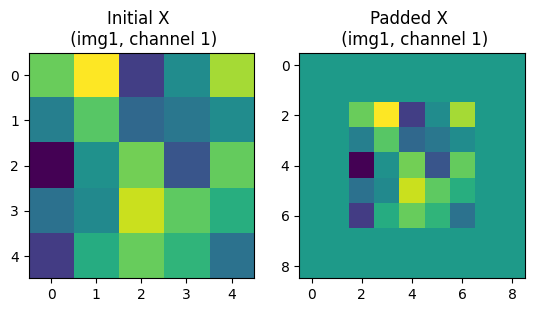

In [9]:
# DO NOT CHANGE THE CODE OF THIS CELL
x = np.random.randn(4, 5, 5, 3)
x_pad = zero_padding(x, 2)

print ("Initial batch size:", x.shape)
print ("Batch size after padding:", x_pad.shape)

assert type(x_pad) == np.ndarray, "Output must be a numpy array"
assert x_pad.shape == (4, 9, 9, 3), f"Wrong shape: {x_pad.shape} != (4, 9, 9, 3)"

assert np.allclose(x_pad[0, 0:1,:, 0], [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 1e-15), "Rows are not padded with zeros"
assert np.allclose(x_pad[0, :, 8:9, 1].transpose(), [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 1e-15), "Columns are not padded with zeros"
assert np.allclose(x_pad[:, 2:7, 2:7, :], x, 1e-15), "Internal values are different"

print("All tests passed.")

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('Initial X \n (img1, channel 1)')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('Padded X \n (img1, channel 1)')
axarr[1].imshow(x_pad[0, :, :, 0])
fig.show()

<a name='2.2'></a>
### 2.2 Convolutional layer

In this part, you will:
* implement a function which represents a single step of convolution (in which you will apply the kernel to a single slice of the input);
* use this function to construct the whole convolutional unit, which takes an input volume and applies a kernel at every slice of the input.


<a name='2.2.1'></a>
#### **TASK 3 (implement single step convolution function)**

In the single step convolution function you should apply convolutional kernel on a slice of the input image.

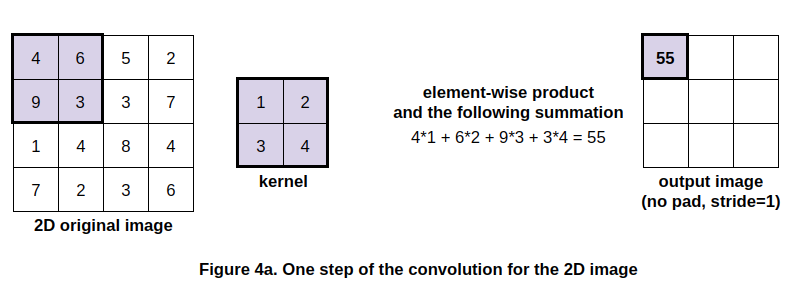

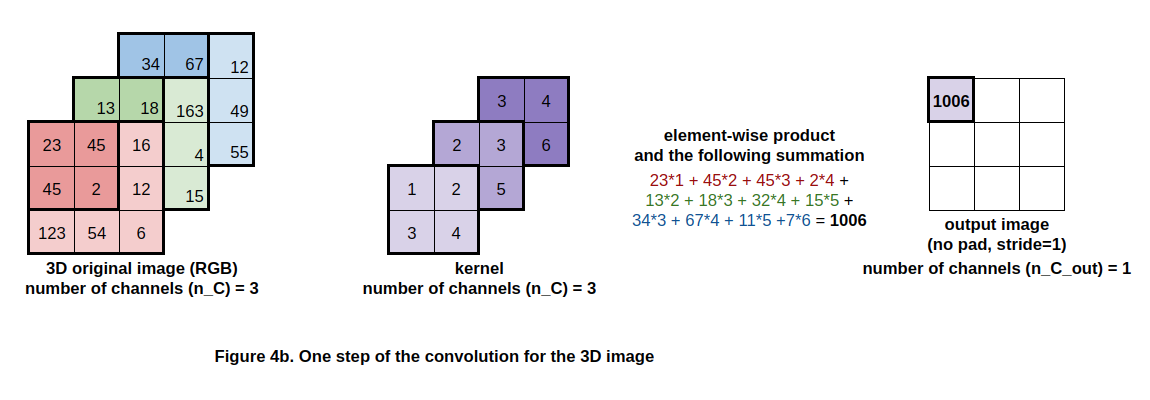

In [10]:
# YOU SHOULD CHANGE THE CODE OF THIS CELL
def conv_step(a_prev_slice, W, b):
    """
    Apply one convolutional kernel (defined by matrix W) on a single slice
    of the output activation of the previous layer (a_prev_slice).

    Required parameters:
    a_prev_slice -- slice of input data of shape (f, f, n_C_prev)
    W -- weight parameters of kernel - python numpy array of shape (f, f, n_C_prev)
    b -- bias parameters - python numpy array of shape (1, 1, 1)

    Returned value:
    Z -- a scalar value (float), the result of convolving the sliding window (W, b) on a slice a_prev_slice of the input data
    """

    # WRITE YOUR CODE HERE
    # Element-wise product between a_prev_slice and W and the following summation.
    Z = np.sum(a_prev_slice * W)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = Z + float(b)

    return Z

In [11]:
# DO NOT CHANGE THE CODE OF THIS CELL
np.random.seed(39)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_step(a_slice_prev, W, b)
print("Z value:", Z)

assert (type(Z) == np.float64 or type(Z) == np.float32), "You must cast the output to float"
assert np.isclose(Z, 3.7943827223933244), "Wrong value"

print("All tests passed.")

Z value: 3.7943827223933244
All tests passed.


C:\Users\dana\AppData\Local\Temp\ipykernel_14724\3531874528.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = Z + float(b)


<a name='2.3.1'></a>
#### **TASK 4 (implement the convolution function - forward pass)**

At this step you will take several kernels and convolve them on the 3D input (output activations of the previous layer). Convolution with each kernel gives you a 2D matrix output. You will then stack these outputs to get a 3D volume again.

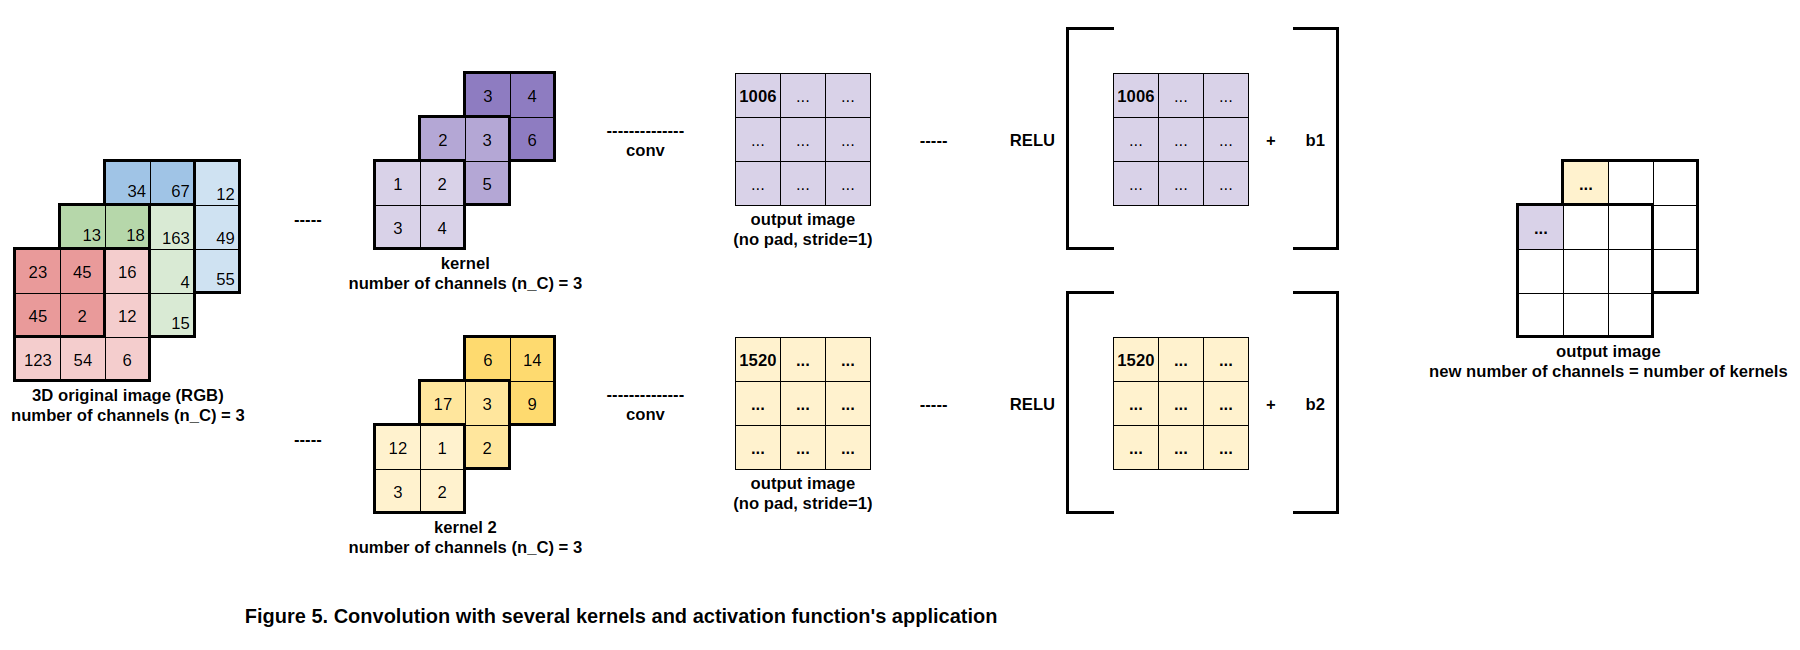

In [13]:
# YOU SHOULD CHANGE THE CODE OF THIS CELL
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function

    Required parameters:
    A_prev -- output activations of the previous layer,
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- kernels' weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"

    Returned value:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """

    # Get dimensions of the previous layer's output
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Get dimensions of kernels' weights
    (f, f, n_C_prev, n_C) = W.shape

    # Get information about stride and pad
    stride = hparameters["stride"]
    pad = hparameters["pad"]

    # Compute the dimensions of the convolution output
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1

    # Initialize the output volume Z with zeros
    Z = np.zeros((m, n_H, n_W, n_C))

    # Create A_prev_pad by padding A_prev
    A_prev_pad = np.pad(A_prev, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=0)

    for i in range(m):               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]   # select i-th training example's padded activation
        for h in range(n_H):
            # Find the vertical start and end of the current "slice"
            vert_start = h * stride
            vert_end = vert_start + f

            for w in range(n_W):
                # Find the horizontal start and end of the current "slice"
                horiz_start = w * stride
                horiz_end = horiz_start + f

                for c in range(n_C):
                    # Define the 3D-slice of a_prev_pad for each kernel
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Convolve the 3D-slice with the current kernel W and bias b, to get back one output neuron
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = np.sum(a_slice_prev * weights) + float(biases)

    # Save information in "cache" for the backpropagation
    cache = (A_prev, W, b, hparameters)

    return Z, cache

In [14]:
# DO NOT CHANGE THE CODE OF THIS CELL
np.random.seed(39)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean:\n", np.mean(Z))
print("Z's shape:", Z.shape)
assert np.isclose(np.mean(Z), 0.13514621895605708), "Wrong value of Z's mean"
assert Z.shape == (2, 5, 7, 8), "Wrong value of Z's mean"
print("All tests passed.")

Z's mean:
 0.13514621895605708
Z's shape: (2, 5, 7, 8)
All tests passed.


C:\Users\dana\AppData\Local\Temp\ipykernel_14724\2828855.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, h, w, c] = np.sum(a_slice_prev * weights) + float(biases)


<a name='3.1'></a>
#### **TASK 5 (implement RELU and sigmoid activation functions)**

Implement RELU and sigmoid activation functions.

**Reminder:**

* $RELU(Z) =  \begin{cases}
   0 &Z<0 \\
   Z &Z\ge 0 \\
 \end{cases}$
* $SIGM(Z) = \frac{1}{1+e^{-Z}}$

In [15]:
# YOU SHOULD CHANGE THE CODE OF THIS CELL
def relu_activation(Z):
  """
    Implements the RELU activation function

    Required parameters:
    Z -- conv output,
        numpy array of shape (m, n_H, n_W, n_C)

    Returned value:
    g -- conv output after applying RELU activation,
        numpy array of shape (m, n_H, n_W, n_C)
    """

  return np.maximum(0, Z)

def sigmoid_activation(Z):
    """
    Implements the sigmoid activation function

    Required parameters:
    Z -- conv output,
        numpy array of shape (m, n_H, n_W, n_C)

    Returned value:
    g -- conv output after applying sigmoid activation,
        numpy array of shape (m, n_H, n_W, n_C)
    """
    return 1 / (1 + np.exp(-Z))

In [16]:
# DO NOT CHANGE THE CODE OF THIS CELL
Z_relu_act = relu_activation(Z)
Z_sigm_act = sigmoid_activation(Z)

assert np.isclose(Z_relu_act[1, 3].mean(), 2.5478636950538975), "Error in RELU function"
assert np.isclose(Z_sigm_act[0, 2].mean(), 0.5480779046894169), "Error in sigmoid function"

assert Z_relu_act.shape == Z.shape, "The output dimension of RELU should remain unchanged"
assert Z_sigm_act.shape == Z.shape, "The output dimension of RELU should remain unchanged"

print("All tests passed.")

All tests passed.


<a name='4'></a>
## 3. Building pooling layer

The convolutional layer is followed by the pooling layer. It is used to reduce the height and width of the input which helps to reduce computation and helps make feature detectors more invariant to the position in the input.

You will implement the two types of pooling in the function `pool_forward`:

* Max-pooling: slides an $(f,f)$ window over the input and stores the max value of the window in the output.

* Average-pooling: slides an $(f,f)$ window over the input and stores the average value of the window in the output.

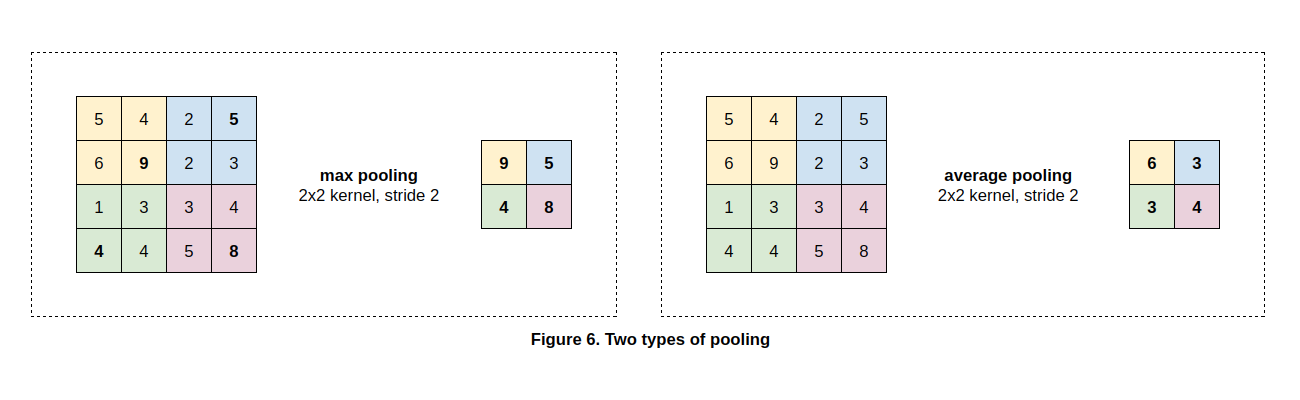

Such pooling layers have no parameters for backpropagation to train. However, they have the window size $f$ hyperparameter, which specifies the height and width of the $f\times f$ window you would compute a max or average over.

<a name='4.1'></a>
#### **TASK 6 (implement the pooling function - forward pass)**

The function must support both modes of pooling operations: max and average.

In [18]:
# YOU SHOULD CHANGE THE CODE OF THIS CELL
def pool_forward(A_prev, hparameters, mode="max"):
    """
    Implements the forward propagation of the pooling function

    Required parameters:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")

    Returned value:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    """

    # Get dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Get kernel size (f) and stride
    f = hparameters["f"]
    stride = hparameters["stride"]

    # Compute the dimensions of the output
    n_H = int((n_H_prev - f) / stride) + 1
    n_W = int((n_W_prev - f) / stride) + 1
    n_C = n_C_prev

    # Initialize output matrix A with zeros
    A = np.zeros((m, n_H, n_W, n_C))

    for i in range(m):                         # loop over the training examples
        for h in range(n_H):
            # Find the vertical start and end of the current "slice"
            vert_start = h * stride
            vert_end = vert_start + f

            for w in range(n_W):
                # Find the horizontal start and end of the current "slice"
                horiz_start = w * stride
                horiz_end = horiz_start + f

                for c in range(n_C):
                    # Define the current slice on the i-th training example of A_prev and channel c
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]

                    # Compute the pooling operation on the slice
                    if mode == "max":  # for max pool
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":  # for avg pool
                        A[i, h, w, c] = np.mean(a_prev_slice)

    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))

    return A

#### **CASE 1 (stride = 1)**

In [19]:
# DO NOT CHANGE THE CODE OF THIS CELL
np.random.seed(39)
A_prev_relu = Z_relu_act
hparameters = {"stride" : 1, "f": 3}

A_relu_maxpool = pool_forward(A_prev_relu, hparameters, mode = "max")
print("Pooling mode: MAX")
print("A.shape: " + str(A_relu_maxpool.shape))
print("A[1, 1]: \n", A_relu_maxpool[1, 1])
print()
A_relu_avgpool = pool_forward(A_prev_relu, hparameters, mode = "average")
print("Pooling mode: AVERAGE")
print("A.shape: " + str(A_relu_avgpool.shape))
print("A[1, 1]:\n", A_relu_avgpool[1, 1])

Pooling mode: MAX
A.shape: (2, 3, 5, 8)
A[1, 1]: 
 [[15.07582045  7.71032783 16.12802279  6.19439118  9.64073771 13.09778915
  11.87773795  4.15039229]
 [15.07582045  7.71032783  8.91557313 12.00545813  7.58041262 13.09778915
   9.08938929  6.02040284]
 [10.3252384   7.71032783  9.0414924  12.00545813  9.86936013 11.65323016
  15.13310406  6.02040284]
 [10.3252384   7.6128846  10.6533091  12.00545813  9.86936013 11.65323016
  15.13310406  6.02040284]
 [10.3252384   5.08554678 10.6533091   3.53708746  9.86936013  9.15017357
  15.13310406  5.95552545]]

Pooling mode: AVERAGE
A.shape: (2, 3, 5, 8)
A[1, 1]:
 [[5.33127645 2.43695417 2.68658157 1.35760691 1.19512353 2.89397807
  2.34817186 1.16126572]
 [3.0368633  3.59191064 1.47554868 3.23213141 1.29944134 4.65134338
  2.1146648  1.61677382]
 [3.36479584 3.02696239 2.79705357 2.67989079 2.39603691 4.78885834
  3.99893908 1.94500584]
 [4.74357183 1.72001721 3.82466639 1.9916251  2.4754728  5.03831263
  5.07730718 1.77522889]
 [5.309727   0.5

**Expected output**

```
Pooling mode: MAX
A.shape: (2, 3, 5, 8)
A[1, 1]:
 [[15.07582045  7.71032783 16.12802279  6.19439118  9.64073771 13.09778915
  11.87773795  4.15039229]
 [15.07582045  7.71032783  8.91557313 12.00545813  7.58041262 13.09778915
   9.08938929  6.02040284]
 [10.3252384   7.71032783  9.0414924  12.00545813  9.86936013 11.65323016
  15.13310406  6.02040284]
 [10.3252384   7.6128846  10.6533091  12.00545813  9.86936013 11.65323016
  15.13310406  6.02040284]
 [10.3252384   5.08554678 10.6533091   3.53708746  9.86936013  9.15017357
  15.13310406  5.95552545]]

Pooling mode: AVERAGE
A.shape: (2, 3, 5, 8)
A[1, 1]:
 [[5.33127645 2.43695417 2.68658157 1.35760691 1.19512353 2.89397807
  2.34817186 1.16126572]
 [3.0368633  3.59191064 1.47554868 3.23213141 1.29944134 4.65134338
  2.1146648  1.61677382]
 [3.36479584 3.02696239 2.79705357 2.67989079 2.39603691 4.78885834
  3.99893908 1.94500584]
 [4.74357183 1.72001721 3.82466639 1.9916251  2.4754728  5.03831263
  5.07730718 1.77522889]
 [5.309727   0.56506075 3.58920188 0.50506954 1.47585424 3.32282541
  3.99106557 1.56488676]]
```

#### **CASE 2 (stride = 2)**

In [20]:
# DO NOT CHANGE THE CODE OF THIS CELL
np.random.seed(39)
A_prev_sigm = Z_sigm_act
hparameters = {"stride" : 2, "f": 3}

A_sigm_maxpool = pool_forward(A_prev_sigm, hparameters, mode = "max")
print("Pooling mode: MAX")
print("A.shape: " + str(A_sigm_maxpool.shape))
print("A[1, 1]: \n", A_sigm_maxpool[1, 1])
print()
A_sigm_avgpool = pool_forward(A_prev_sigm, hparameters, mode = "average")
print("Pooling mode: AVERAGE")
print("A.shape: " + str(A_sigm_avgpool.shape))
print("A[1, 1]:\n", A_sigm_avgpool[1, 1])

Pooling mode: MAX
A.shape: (2, 2, 3, 8)
A[1, 1]: 
 [[0.99999918 0.99955203 0.99969061 0.99963987 0.99787162 0.9982779
  0.99970094 0.99872024]
 [0.99996721 0.99955203 0.99988162 0.99796331 0.99999216 0.99999131
  0.99999973 0.99922657]
 [0.99996721 0.40556542 0.99997638 0.9717248  0.99994827 0.99989381
  0.99999973 0.99741522]]

Pooling mode: AVERAGE
A.shape: (2, 2, 3, 8)
A[1, 1]:
 [[0.47378084 0.50547534 0.53372083 0.46169357 0.30139256 0.51171529
  0.35814472 0.60647678]
 [0.45569665 0.4424509  0.55431938 0.58155932 0.6349081  0.72126667
  0.57716369 0.65838475]
 [0.98039251 0.11772363 0.35284311 0.39943482 0.43790564 0.83034389
  0.44518352 0.43990833]]


**Expected output**

```
Pooling mode: MAX
A.shape: (2, 2, 3, 8)
A[1, 1]:
 [[0.99999918 0.99955203 0.99969061 0.99963987 0.99787162 0.9982779
  0.99970094 0.99872024]
 [0.99996721 0.99955203 0.99988162 0.99796331 0.99999216 0.99999131
  0.99999973 0.99922657]
 [0.99996721 0.40556542 0.99997638 0.9717248  0.99994827 0.99989381
  0.99999973 0.99741522]]

Pooling mode: AVERAGE
A.shape: (2, 2, 3, 8)
A[1, 1]:
 [[0.47378084 0.50547534 0.53372083 0.46169357 0.30139256 0.51171529
  0.35814472 0.60647678]
 [0.45569665 0.4424509  0.55431938 0.58155932 0.6349081  0.72126667
  0.57716369 0.65838475]
 [0.98039251 0.11772363 0.35284311 0.39943482 0.43790564 0.83034389
  0.44518352 0.43990833]]
```

<a name='5'></a>
## 4. Backpropogation in convolutional layer

This part of the notebook is devoted to backward propagation in convolutional neural networks. All modern DL frameworks allow you to implement only forward propogation and take care of the backprop themselves. But if you want to understand more deeply how backprop in a convolutional network looks like, then this part is for you.

### **Theoretical aspects of backpropogation in CNNs**
#### **Computing dA**
This is the formula for computing $dA$ with respect to the cost for a certain kernel $W_c$ and a given training example:

$$dA \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw}$$

Where $W_c$ is a convolution kernel and $dZ_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the $h_{th}$ row and $w_{th}$ column.


#### **Computing dW**
This is the formula for computing $dW_c$ ($dW_c$ is the derivative of one kernel) with respect to the loss:

$$dW_c  \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}$$

Where $a_{slice}$ corresponds to the slice which was used to generate the activation $Z_{hw}$.

#### **Computing db**

This is the formula for computing $db$ with respect to the cost for a certain kernel $W_c$:

$$db = \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} dZ_{hw}$$

<a name='5.1'></a>
#### **TASK 7 (implement the convolution function - backward pass)**

In [21]:
# YOU SHOULD CHANGE THE CODE OF THIS CELL
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function

    Required parameters:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()

    Returned value:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """

    # Get information from "cache"
    (A_prev, W, b, hparameters) = cache

    # Get dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Get dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape

    # Get stride and pad
    stride = hparameters["stride"]
    pad = hparameters["pad"]

    # Get dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape

    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # Pad A_prev and dA_prev
    A_prev_pad = np.pad(A_prev, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=0)
    dA_prev_pad = np.pad(dA_prev, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=0)

    for i in range(m):                       # loop over the training examples
        # Select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    # Find the corners of the current "slice"
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    # Define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Update gradients for the window and the kernel's parameters
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]

        # Set the ith training example's dA_prev to the unpadded da_prev_pad
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]

    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

    return dA_prev, dW, db

In [22]:
# DO NOT CHANGE THE CODE OF THIS CELL
np.random.seed(39)
A_prev = A_relu_maxpool
W = np.random.randn(2, 2, 8, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 1}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)

print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

assert type(dA) == np.ndarray, "Output must be a np.ndarray"
assert type(dW) == np.ndarray, "Output must be a np.ndarray"
assert type(db) == np.ndarray, "Output must be a np.ndarray"

assert dA.shape == (2, 3, 5, 8), f"Wrong shape for dA  {dA.shape} != (2, 3, 5, 8)"
assert dW.shape == (2, 2, 8, 8), f"Wrong shape for dW {dW.shape} != (2, 2, 8, 8)"
assert db.shape == (1, 1, 1, 8), f"Wrong shape for db {db.shape} != (1, 1, 1, 8)"

assert np.isclose(np.mean(dA), 431.18801309512406), "Wrong values for dA"
assert np.isclose(np.mean(dW), -630.649747716205), "Wrong values for dW"
assert np.isclose(np.mean(db), -127.35125113717262), "Wrong values for db"

print("All tests passed.")

dA_mean = 431.18801309512406
dW_mean = -630.6497477162045
db_mean = -127.35125113717262
All tests passed.


C:\Users\dana\AppData\Local\Temp\ipykernel_14724\2828855.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, h, w, c] = np.sum(a_slice_prev * weights) + float(biases)
